# Early Detection of Crop Stress From Thermal Infrared Imagery
![Hydrosat](https://uploads-ssl.webflow.com/61e4aee27ac4a95d23ab9609/61e9d6f5d6578e8c7c0cca8f_solutions-thermal-min.jpg)

In [1]:
import base64
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import os
import pystac
import requests
import xarray as xr
import rioxarray as rxr
import rasterio as rio

#from botocore.exceptions import ClientError
from datetime import date
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from distutils.command import sdist
from matplotlib import pyplot as plt
from pyproj.crs import CRS
from pystac_client import Client
from pprint import pprint
from shapely.geometry import box, mapping, Point, Polygon
from sklearn.linear_model import LinearRegression

# Project specific packages
from FH_Hydrosat import FH_StackedDataset
from FH_Hydrosat import FH_Hydrosat
from herbie import FastHerbie
#import synoptic.services as ss
#from synoptic.services import stations_timeseries

os.environ['USE_PYGEOS'] = '0'


### <span style="color:green">FUNCTIONS.  No user editing is required.</span>

In [332]:
# ---------------------------------------------------------------------------------

def create_clip_polygon(geom, ds, buffer):
    """
    Create a polygon that we will use for clipping the big dataset.

    Parameters:
    ----------
    geom: dict
        Dictionary of lat and lon of center point of AOI.

    Returns:
    -------
    poly: dataframe
        Contains geometry of a square to be used for clipping.
    """
    # Using the point coords defined earlier, create a df with the point geometry.
    p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])
    point_df = gpd.GeoDataFrame({'geometry':[p_geom]}, crs=CRS.from_epsg(4326))

    # Define a buffer size (for each side of the point.
    # Reproject the point df and create the new polygon.
    raster_crs = CRS.from_wkt(ds.spatial_ref.crs_wkt)
    buffer_dist = buffer # 1km in local UTM zone

    # create a square buffer
    poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) 

    return(poly_df)

# ---------------------------------------------------------------------------------

def stac_tile_search(collection, geom, start_date, end_date):
    """
    Log into STAC and search for a specified image collection.

    Parameters:
    ----------
    collection: list
        List of tiles found in STAC.

    geom: 
        Point location to search.

    start_date, end_date: str
        Dates to search between.

    Returns:
    -------
    """
    search = catalog.search(
        collections = collection,
        intersects = geom,
        datetime = [start_date, end_date],
        max_items = 1000
    )
    print ("----", search.get_all_items())
    # found_items = list(search.items()) # for pystac-client >= 0.4.0
    found_items = list(search.get_all_items()) # for pystac-client < 0.4.0

    # Filter out only the newest version of MODIS.
    if collection == 'prepped_inputs_mcd43a4':
        version_str = '061'
        new_list = [i for i in found_items if version_str in i.id]
        found_items = new_list

    found_items.reverse() # make the results ascending in time

    num_tiles = len(found_items)
    print ("Searching {} colllection .... images available: {}\n".format(collection, num_tiles))

    return (found_items, num_tiles)

# ---------------------------------------------------------------------------------

def create_aoi_image_stack(items, num_tiles, geom, asset, buffer):
    '''
    Gets images, stacks them and sorts them by date and clips them down to a smaller
    AOI size.

    Parameters:
    -----------
    itmes: list 
        List of available images.
    num_tiles: int
        Number of tiles to download (days)
    asset: str
        Name of asset to get.
    geom: x,y coords
        Coordinates around which to build a polygon
    buffer: int
        Buffer around the x,y for creating the AOI rectangele.  In meters.

    Returns:
    --------
    aoi_stack_ds: dataset as FH_StackedDataset object.
        Stack of images clipped to AOI.

    '''
    images = FH_Hydrosat(items[:num_tiles], asset=asset)

    # Stacks all the files into a dataset and then return a FH_StackedDataset object.
    stacked_images = images.stack()
    # Sort the dataset by time.
    ds = stacked_images.ds.sortby('time')

    # Create polygon Area of Interest (AOI for which to sample.).
    clip_poly_df = create_clip_polygon(geom, ds, buffer=buffer)
    # Use AOI polygon to clip the dataset dwon to size and make it into a FH_StackedDataset object.
    clipped = FH_StackedDataset(ds.rio.clip(clip_poly_df.geometry))
    aoi_stack_ds = clipped.ds

    return (aoi_stack_ds, clip_poly_df)

 # ---------------------------------------------------------------------------------   
def extract_time_series(items, asset, bbox, tol, pad, band, var_name):
    '''
    Uses FH_Hydrosat class method point_time_series_from_items()
    to extract only a time-series.

    Parameters:
    -----------
    items: list
        Image items returned from STAC search.
    bbox: 
        Bounding box of coordinates for seacrh site.
    tol: int
        A search parameter in meters for finding point data.
    var_name: str
        Dataframe column name for data extracted.
    asset: str
        Search parameter for type of asset to be searched.
    
    Returns:
    -------
    lst_df: dataframe
        Dataframe containing date time series.
    '''
    # Sample the LST items.
    lst_res = FH_Hydrosat(items, asset=asset)

    # Set the point for time-series extraction.
    point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)
    
    # Extract time-series data using function.
    band = int(band) # band needs to be an int because it comes in as a string.
    lst_k  = lst_res.point_time_series_from_items(point_wgs84, tol=tol, nproc=6, band=band) 

    # Create a datetime dataframe
    lst_dt = lst_res.datetime
    lst_df = pd.DataFrame({var_name: lst_k,
                       'datetime': pd.to_datetime(lst_dt)}).sort_values(by='datetime')
    
    # Get the date in the correct/consistent format.
    lst_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in lst_df['datetime']]
    lst_df['date'] = pd.to_datetime(lst_df['date'])
    lst_df.drop(columns='datetime', inplace=True)
    lst_df.set_index('date', drop=True, inplace=True)
    
    return (lst_df)

# ---------------------------------------------------------------------------------

def get_hrrr_point_data(lat, lon, start, days):
    ''' 
    Fetch met data from the HRRR model system.
    Herbie package needs to be installed:
    https://herbie.readthedocs.io/en/stable/
    ${HOME}/.config/herbie/config.toml

    Parameters:
    ----------
    lat, lon: float
        Coords from which to pull grid cell data. 
    start: str
        This is the start date for which data will be retrieved.
    days: int
        Number of days of data to retrieve.

    Return:
    -------
    ds_point: xarray dataset
        Met data for specified point.
    '''
    start_hr_time = "{} 18:30".format(start)
    # Create a range of dates
    DATES = pd.date_range(
        start=start_hr_time,
        periods=days,
        freq="1D",
    )

    # Define forecast lead time (or analysis).
    fxx = range(0, 1)

    # -----------------------------------------------
    # For long time-series analyses
    # -----------------------------------------------
    FH = FastHerbie(DATES, model="hrrr", fxx=fxx)

    FH.download("TMP:2 m")
    t_ds = FH.xarray("TMP:2 m", remove_grib=False)

    FH.download("DPT:2 m")
    td_ds = FH.xarray("DPT:2 m", remove_grib=False)
    # -----------------------------------------------
    # For real-time fetching of HRRR data.
    # -----------------------------------------------
    # Make FastHerbie Object.
    # FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    # Read a subset of the data with xarray.
    # ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------

    # Get data values nearest single point
    t_ds_point = t_ds.herbie.nearest_points(points=(lon, lat))
    td_ds_point = td_ds.herbie.nearest_points(points=(lon, lat))
   
    return (t_ds_point, td_ds_point)

# ---------------------------------------------------------------------------------
def get_synoptic_obs(station):
    # ---------------------------------------------------------------------
    # Request a single station by listing the station id.  
    # ---------------------------------------------------------------------
    params = dict(
        stid=station,
        vars=['air_temp', 'dew_point_temperature'],
        start=datetime(2020, 4, 1),
        end=datetime(2020, 10, 30)
    )
    data = stations_timeseries(verbose='HIDE', **params)

    # Filter data to get only 00z obs.
    sfc_obs = data.loc[(data.index.hour == 17) & (data.index.minute == 30)]
    sfc_obs.drop(columns='dew_point_temperature_set_1', inplace=True)
    # convert datetime column to just date
    sfc_obs['time'] = sfc_obs.index.date
    sfc_obs.reset_index(inplace=True)
    sfc_obs.set_index('time', inplace=True)

    # Change date format to be consistent.
    sfc_obs.index = pd.to_datetime(sfc_obs.index)
    sfc_obs.index = sfc_obs.index.strftime('%Y-%m-%d')

    return (sfc_obs)

# ---------------------------------------------------------------------------------

def read_ameriflux(data_path):

    print ('Reading file {}'.format(data_path))
    
    df = pd.read_csv(data_path, header=0, na_values=[-9999.000000])

    # Save value column names
    value_cols = df.columns[2:]

    # Convert timestamp objects
    df['start'] = df['TIMESTAMP_START'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M.0")
        )
    df['end'] = df['TIMESTAMP_END'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M.0")
        )

    # Convert obs to UTC time.txt.
    # # UTC_OFFSET is a global var.
    df['start'] = df['start'] + timedelta(hours=UTC_OFFSET)
    df['end'] = df['end'] + timedelta(hours=UTC_OFFSET)
    df['start'] = df['start'].dt.tz_localize('UTC')
    df['end'] = df['end'].dt.tz_localize('UTC')

    # Drop NA
    df = df.dropna(subset=value_cols, how='all')

    df = df.set_index('start')
    col_order = (['end', 'TIMESTAMP_START', 'TIMESTAMP_END'] 
                 + value_cols.to_list())
    df = df[col_order]

    return df

### <span style="color:green">Login to STAC.</span>

In [3]:
# Open credentials file.
with open('../secrets/creds.json') as f:
    creds = json.loads(f.read())

# Endecode the `username:password` combination 
# and use it to authorize access to the STAC API given by the `cat_url` 
# endpoint.userpass = f"{creds['username']}:{creds['password']}"
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

### <span style="color:green">Set up analysis.  User edits required in cell below.</span>

Landsat in the Corn & Alfalfa fields is available from Sept 1, 2021 to Dec 30, 2022

In [462]:
# ---------------------------------------------------------------------------
# USER EDITS REQUIRED -------------------------------------------------------
# ---------------------------------------------------------------------------

analysis = 'Corn'

# Want met obs in UTC time to match satellites.
UTC_OFFSET = 7

# Insitu point locations
insitu_met_points = {
    'Corn': [38.1091, -121.5351],
    'Alfalfa': [38.0992, -121.4993]
}

# Center point of crop fields.
crop_center_points = {
    'Corn': [-121.5360, 38.1095],
    'Alfalfa': [-121.5015, 38.0994],
    'Ames': [-93.701, 42.000],
}

# Define size of AOI.
#    Length    x    Width 
# (buffer * 2) x (buffer * 2)
buffer = 250

# Specify dates & hour for LST analysis.
# start_date = "2016-08-13T00:00:00Z"
# end_date = "2022-05-26T00:00:00Z"
start = "2019-01-01"  
end = "2022-12-30"  
hr_s = "00:00:00"  
hr_e = '23:59:59'

# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

# Define paths to data
data_path = os.path.join('../data', 'Ameriflux')

if analysis == 'Alfalfa':
    bbox = [-121.5027, 38.0986, -121.5003, 38.1000]
    met_path = os.path.join(data_path, 
                                'US-Bi1_HH_201608130000_202301010000.csv')
elif analysis == 'Corn':
    bbox = [-121.5365, 38.1098, -121.5355, 38.1091]
    met_path = os.path.join(data_path,
                                'US-Bi2_HH_201704270000_202301010000.csv')
elif analysis == 'Rice':
    met_path = os.path.join(data_path,
                                'AMF_US-DS3_BASE-BADM_1-5',
                                'AMF_US-DS3_BASE_HH_1-5.csv')

# Create dict of coords.  Will be used to create a polygon for our AOI.
geom = {'type': 'Point', 'coordinates': crop_center_points[analysis]} 

# We need the total num of days for the analysis to get hrrr data.
f = start.split("-")
l = end.split("-")

# Creating dates from split arrays above.
f_dt = date(int(f[0]), int(f[1]), int(f[2]))  
l_dt = date(int(l[0]), int(l[1]), int(l[2]))  
num_days = (l_dt - f_dt)
num_days = num_days.days

# Need to do some formating for various requirements.
hr_s_form = "T{}Z".format(hr_s)
hr_e_form = "T{}Z".format(hr_e)
start_date = start + hr_s_form
end_date = end + hr_e_form

### <span style="color:green">Corn: Search and get a list of available NDVI images.</span>

In [5]:
# Collection to search for.
# collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat"]
# collections = ["pydms_sharpened_landsat"]
collections = ["prepped_inputs_mcd43a4"]

# Search STAC for available images.
(corn_items, num_tiles) = stac_tile_search(collections, geom, start_date, end_date)

print (f"First date: {corn_items[0]}")
print (f"Last date: {corn_items[-1]}")

---- <pystac.item_collection.ItemCollection object at 0x172852490>
Searching ['prepped_inputs_mcd43a4'] colllection .... images available: 735

First date: <Item id=MCD43A4.061_20210109_10SFH>
Last date: <Item id=MCD43A4.006_20221230_10SFH>


### <span style="color:green">Alfalfa: Search and get a list of available NDVI images.</span>

In [108]:
# Collection to search for.
# collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat"]
# collections = ["pydms_sharpened_landsat"]
collections = ["prepped_inputs_mcd43a4"]

# Search STAC for available images.
(alfalfa_items, num_tiles) = stac_tile_search(collections, geom, start_date, end_date)

print (f"First date: {alfalfa_items[0]}")
print (f"Last date: {alfalfa_items[-1]}")

---- <pystac.item_collection.ItemCollection object at 0x177b59c10>
Searching ['prepped_inputs_mcd43a4'] colllection .... images available: 735

First date: <Item id=MCD43A4.061_20210109_10SFH>
Last date: <Item id=MCD43A4.006_20221230_10SFH>


### <span style="color:green">Corn: Get NDVI data into dataframe. </span>

In [6]:
# Check if crop rotation.

# Extract red
asset = 'surface_reflectance'
var_name = 'red_sr'
tolerance = 1000
pad = 0
band = 0
(red_time_series_df) = extract_time_series(corn_items, asset, bbox, tolerance, pad, band, var_name)
        
# Extract nir
asset = 'surface_reflectance'
var_name = 'nir_sr'
tolerance = 1000
pad = 0
band = 1
(nir_time_series_df) = extract_time_series(corn_items, asset, bbox, tolerance, pad, band, var_name)
        
# Copute NDVI
corn_ndvi = ((nir_time_series_df['nir_sr'] - red_time_series_df['red_sr']) / (nir_time_series_df['nir_sr'] + red_time_series_df['red_sr']))
        
# Give the ndvi data column an appropriate name.
var_name = "prepped_inputs_mcd43a4_corn_ndvi"
corn_ndvi_df = pd.DataFrame()
corn_ndvi_df[var_name] = corn_ndvi

using 6 processes to sample 735 assets
using 6 processes to sample 735 assets


### <span style="color:green">Alfalfa: Get NDVI data into dataframe. </span>

In [109]:
# Check if crop rotation.

# Extract red
asset = 'surface_reflectance'
var_name = 'red_sr'
tolerance = 1000
pad = 0
band = 0
(red_time_series_df) = extract_time_series(corn_items, asset, bbox, tolerance, pad, band, var_name)
        
# Extract nir
asset = 'surface_reflectance'
var_name = 'nir_sr'
tolerance = 1000
pad = 0
band = 1
(nir_time_series_df) = extract_time_series(corn_items, asset, bbox, tolerance, pad, band, var_name)
        
# Copute NDVI
alfalfa_ndvi = ((nir_time_series_df['nir_sr'] - red_time_series_df['red_sr']) / (nir_time_series_df['nir_sr'] + red_time_series_df['red_sr']))
        
# Give the ndvi data column an appropriate name.
var_name = "prepped_inputs_mcd43a4_alfalfa_ndvi"
alfalfa_ndvi_df = pd.DataFrame()
alfalfa_ndvi_df[var_name] = alfalfa_ndvi

using 6 processes to sample 735 assets
using 6 processes to sample 735 assets


### <span style="color:green">Print out a file with ndvi values to get dates from..</span>

In [133]:
with open("corn-ndvi.txt", "a") as f:

    for row in corn_ndvi_df.itertuples(index = True):
      print (getattr(row,'Index'), getattr(row, "prepped_inputs_mcd43a4_corn_ndvi"), file=f)

# Corn dates where ndvi >= 0.5:
# 2021-06-06 - 2021-09-06 & 2022-06-09 - 2022-09-07

### <span style="color:green">Plot NDVI for Corn field and alfalfa field..</span>

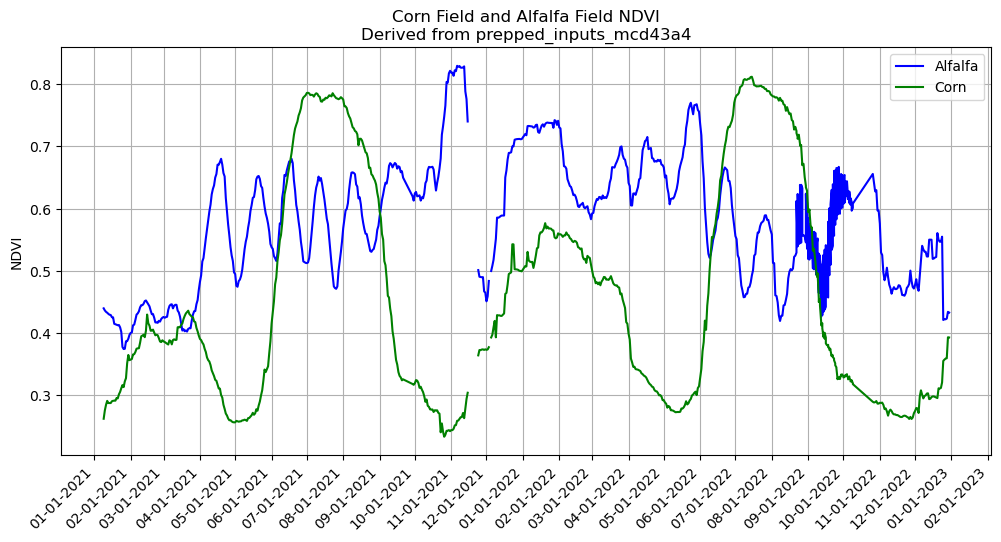

In [111]:
import matplotlib.dates as mdates

# Merge the corn and alfalfa ndvi df's together.
ndvi_df = pd.merge(
    corn_ndvi_df, alfalfa_ndvi_df, 
    left_index=True, right_index=True, how = 'outer')  

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(ndvi_df['prepped_inputs_mcd43a4_alfalfa_ndvi'], c='blue', label='Alfalfa')
ax.plot(ndvi_df['prepped_inputs_mcd43a4_corn_ndvi'], c='green', label="Corn")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))
plt.gcf().autofmt_xdate()

plt.title('Corn Field and Alfalfa Field NDVI\nDerived from prepped_inputs_mcd43a4')
plt.grid(True)
plt.ylabel('NDVI')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Get insitu MET data for CORN.

In [335]:
met_path = os.path.join(data_path,
                            'US-Bi2_HH_201704270000_202301010000.csv')
met_df = read_ameriflux(met_path)

# Corn dates where ndvi >= 0.5:
# 2021-06-06 - 2021-09-06 & 2022-06-09 - 2022-09-07

start1 = '2021-06-06 18:30:00+00:00' 
end1 = '2021-09-06 18:30:00+00:00'

start2 = '2022-06-09 18:30:00+00:00' 
end2 = '2022-09-07 18:30:00+00:00'

met_df1 = met_df.loc[start1:end1]
met_df2 = met_df.loc[start2:end2]

frames = [met_df1, met_df2]
met_df = pd.concat(frames)

met_df.index = pd.to_datetime(met_df.index)

match_timestamp = "18:30:00"
corn_met_df = met_df.loc[met_df.index.strftime("%H:%M:%S") == match_timestamp]

corn_met_df['TA']
corn_met_df['VPD']

Reading file ../data/Ameriflux/US-Bi2_HH_201704270000_202301010000.csv


start
2021-06-06 18:30:00+00:00    20.355438
2021-06-07 18:30:00+00:00    18.092844
2021-06-08 18:30:00+00:00    13.311746
2021-06-09 18:30:00+00:00    13.451180
2021-06-10 18:30:00+00:00    13.982454
                               ...    
2022-09-03 18:30:00+00:00    36.502086
2022-09-04 18:30:00+00:00    34.961680
2022-09-05 18:30:00+00:00    49.001603
2022-09-06 18:30:00+00:00    56.491049
2022-09-07 18:30:00+00:00    50.007558
Name: VPD, Length: 184, dtype: float64

In [334]:
met_path = os.path.join(data_path, 
                            'US-Bi1_HH_201608130000_202301010000.csv')
print (met_path)
met_df = read_ameriflux(met_path)

# Corn dates where ndvi >= 0.5:
# 2021-06-06 - 2021-09-06 & 2022-06-09 - 2022-09-07

start1 = '2021-06-06 18:30:00+00:00' 
end1 = '2021-09-06 18:30:00+00:00'

start2 = '2022-06-09 18:30:00+00:00' 
end2 = '2022-09-07 18:30:00+00:00'

met_df1 = met_df.loc[start1:end1]
met_df2 = met_df.loc[start2:end2]

frames = [met_df1, met_df2]
met_df = pd.concat(frames)

met_df.index = pd.to_datetime(met_df.index)

match_timestamp = "18:30:00"
alfalfa_met_df = met_df.loc[met_df.index.strftime("%H:%M:%S") == match_timestamp]

alfalfa_met_df['TA']
alfalfa_met_df['VPD']

../data/Ameriflux/US-Bi1_HH_201608130000_202301010000.csv
Reading file ../data/Ameriflux/US-Bi1_HH_201608130000_202301010000.csv


start
2021-06-06 18:30:00+00:00    21.693620
2021-06-07 18:30:00+00:00    19.058197
2021-06-08 18:30:00+00:00    14.111962
2021-06-09 18:30:00+00:00    13.870611
2021-06-10 18:30:00+00:00    14.052134
                               ...    
2022-09-03 18:30:00+00:00    36.334282
2022-09-04 18:30:00+00:00    35.424641
2022-09-05 18:30:00+00:00    50.050680
2022-09-06 18:30:00+00:00    55.273295
2022-09-07 18:30:00+00:00    50.805830
Name: VPD, Length: 184, dtype: float64

### <span style="color:green">Set dates for LST analysis based on NDVI range. </span>

In [463]:
# Set dates for corn where ndvi >= 0.5
start1 = '2021-06-06T00:00:00Z' 
end1 = '2021-09-06T00:00:00Z'

start2 = '2022-06-09T00:00:00Z' 
end2 = '2022-09-07T00:00:00Z'


### <span style="color:green">Search and get a list of available LST images.</span>

In [464]:
# Collection to search for.
# collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat"]
# collections = ["pydms_sharpened_landsat"]
#collections = ["pydms_sharpened_landsat"]
collections = ["starfm_predictions_modis_landsat"]
asset = 'lst'

# Search STAC for available images.
(found_items_1, num_tiles) = stac_tile_search(collections, geom, start1, end1)

print (f"First date start1: {found_items_1[0]}")
print (f"Last date end1: {found_items_1[-1]}")


# Search STAC for available images.
(found_items_2, num_tiles) = stac_tile_search(collections, geom, start2, end2)

print (f"First date start2: {found_items_2[0]}")
print (f"Last date end2: {found_items_2[-1]}")

---- <pystac.item_collection.ItemCollection object at 0x180b37250>


TypeError: 'list' object is not callable

### <span style="color:green">Extract LST data for corn for selected dates.</span>

In [ ]:
# Extract data from AOI. ----------------
(aoi_lst_da1, aoi_df) = create_aoi_image_stack(found_items_1, num_tiles, geom, asset, buffer)
(aoi_lst_da2, aoi_df) = create_aoi_image_stack(found_items_2, num_tiles, geom, asset, buffer)

In [ ]:
sns.boxplot(x=aoi_lst_da1.index.dayofyear,
            y=df_year['NDVI'],
            ax=ax).set(title=year)

### Get max, min, mean for AOI for boxplot.

In [361]:
# Get max, min, mean
max1 = aoi_lst_da1.quantile(.9, dim=["x", "y"]).values
min1 = aoi_lst_da1.quantile(.1, dim=["x", "y"]).values
mean1 = aoi_lst_da1.mean(dim=["x", "y"]).values
std1 = aoi_lst_da1.std(dim=["x", "y"]).values

max2 = aoi_lst_da2.quantile(.9, dim=["x", "y"]).values
min2 = aoi_lst_da2.quantile(.1, dim=["x", "y"]).values
mean2 = aoi_lst_da2.mean(dim=["x", "y"]).values
std2 = aoi_lst_da2.std(dim=["x", "y"]).values

# Concatenate them together so we have 3 values per row.
lst_box_list1 = np.concatenate((max1, min1, mean1, std1), axis=1)
lst_box_list2 = np.concatenate((max2, min2, mean2, std2), axis=1)

# Convert numpy arrays to a dataframe.
lst_box_list_df1 = pd.DataFrame(lst_box_list1, columns = ['max_lst','min_lst','mean_lst', 'std_lst'])
lst_box_list_df2 = pd.DataFrame(lst_box_list2, columns = ['max_lst','min_lst','mean_lst', 'std_lst'])

# Use dates from earlier datarray.
dates1 = aoi_lst_da1.time
dates2 = aoi_lst_da2.time

# Convert dataarrays timestamp to correct format.
lst_box_list_df1['date'] = pd.to_datetime(dates1).strftime('%Y-%m-%d')
lst_box_list_df1.set_index('date', inplace=True)

lst_box_list_df2['date'] = pd.to_datetime(dates2).strftime('%Y-%m-%d')
lst_box_list_df2.set_index('date', inplace=True)


In [ ]:
lst_box_list_df2

### Get LST for point location.

In [91]:
# Extract data from point. -----------------
(lst_time_series_df1) = (extract_time_series(found_items_1, asset,bbox, int(40), asset, int(0), 'fused_lst'))
(lst_time_series_df2) = (extract_time_series(found_items_2, asset,bbox, int(40), asset, int(0), 'fused_lst'))

# Change date format to be consistent.
lst_time_series_df1.index = pd.to_datetime(lst_time_series_df1.index)
lst_time_series_df2.index = pd.to_datetime(lst_time_series_df2.index)

lst_time_series_df1.index = lst_time_series_df1.index.strftime('%Y-%m-%d')
lst_time_series_df2.index = lst_time_series_df2.index.strftime('%Y-%m-%d')

using 6 processes to sample 11 assets
using 6 processes to sample 22 assets


### <span style="color:green">Now get mean LST data for selected dates. </span>

In [14]:
# Get mean of all pixels for each time-step.
aoi_mean_lst_da1 = aoi_lst_da1.isel(band=0).mean(dim=["x", "y"])
aoi_mean_lst_da2 = aoi_lst_da2.isel(band=0).mean(dim=["x", "y"])

# Convert to dataframe.
aoi_mean_lst_df1 = aoi_mean_lst_da1.to_dataframe(name='starfm_lst')
aoi_mean_lst_df2 = aoi_mean_lst_da2.to_dataframe(name='starfm_lst')

# Change date format to be consistent.
aoi_mean_lst_df1.index = pd.to_datetime(aoi_mean_lst_df1.index)
aoi_mean_lst_df2.index = pd.to_datetime(aoi_mean_lst_df2.index)

aoi_mean_lst_df1.index = aoi_mean_lst_df1.index.strftime('%Y-%m-%d')
aoi_mean_lst_df2.index = aoi_mean_lst_df2.index.strftime('%Y-%m-%d')

# Create dfs with a complete list of dates.
days1 = pd.date_range(start1, end1)
dates_df1 = pd.DataFrame({'time': days1})
dates_df1['time'] = pd.to_datetime(dates_df1.time)
dates_df1.set_index('time', inplace=True)

days2 = pd.date_range(start2, end2)
dates_df2 = pd.DataFrame({'time': days2})
dates_df2['time'] = pd.to_datetime(dates_df2.time)
dates_df2.set_index('time', inplace=True)

# Change date format to be consistent.
dates_df1.index = dates_df1.index.strftime('%Y-%m-%d')
dates_df2.index = dates_df2.index.strftime('%Y-%m-%d')

# Merge each df into master dataframe.
# Merge on index (date) and keep all rows from both dfs (inner join).
lst_df1 = pd.merge(
    dates_df1, aoi_mean_lst_df1, 
    left_index=True, right_index=True, how = 'outer')  

lst_df2 = pd.merge(
    dates_df2, aoi_mean_lst_df2, 
    left_index=True, right_index=True, how = 'outer')  

# Interpolate missing values ---------------------------------------------
# interpd_aoi_lst_df = lst_df.interpolate(method='linear', inplace=False)
# Drop uneeded columns.
# interpd_aoi_lst_df.drop(columns=['band', 'spatial_ref'], inplace=True)

### Get MET for each of the dates for which we have LST.

In [336]:
corn_met_df1 = corn_met_df[corn_met_df.index.strftime('%Y-%m-%d').isin(aoi_mean_lst_df1.index)]
corn_met_df2 = corn_met_df[corn_met_df.index.strftime('%Y-%m-%d').isin(aoi_mean_lst_df2.index)]

alfalfa_met_df1 = alfalfa_met_df[alfalfa_met_df.index.strftime('%Y-%m-%d').isin(aoi_mean_lst_df1.index)]
alfalfa_met_df2 = alfalfa_met_df[alfalfa_met_df.index.strftime('%Y-%m-%d').isin(aoi_mean_lst_df2.index)]

### Get HRRR met 

In [ ]:
# Need number of days of met we want.  Get full range first.
l1 = len(pd.date_range(start='2021-06-06', end='2021-09-06'))
l2 = len(pd.date_range(start='2022-06-09', end='2022-09-07'))

# Use dictinary to get lat, lon.
hrrr_ta_ds1, hrrr_td_ds1 = get_hrrr_point_data(insitu_met_points['Corn'][0], insitu_met_points['Corn'][1], '2021-06-06', l1)
hrrr_ta_ds2, hrrr_td_ds2 = get_hrrr_point_data(insitu_met_points['Corn'][0], insitu_met_points['Corn'][1], '2022-06-09', l2)

ds1 = hrrr_ta_ds1.to_dataframe()
ds2 = hrrr_ta_ds2.to_dataframe()

ds1.set_index(pd.to_datetime(ds1.valid_time.values).strftime('%Y-%m-%d'), inplace=True)
ds2.set_index(pd.to_datetime(ds2.valid_time.values).strftime('%Y-%m-%d'), inplace=True)

hrrr_met_ds1 = ds1[ds1.index.isin(aoi_mean_lst_df1.index)]
hrrr_met_ds2 = ds2[ds2.index.isin(aoi_mean_lst_df2.index)]


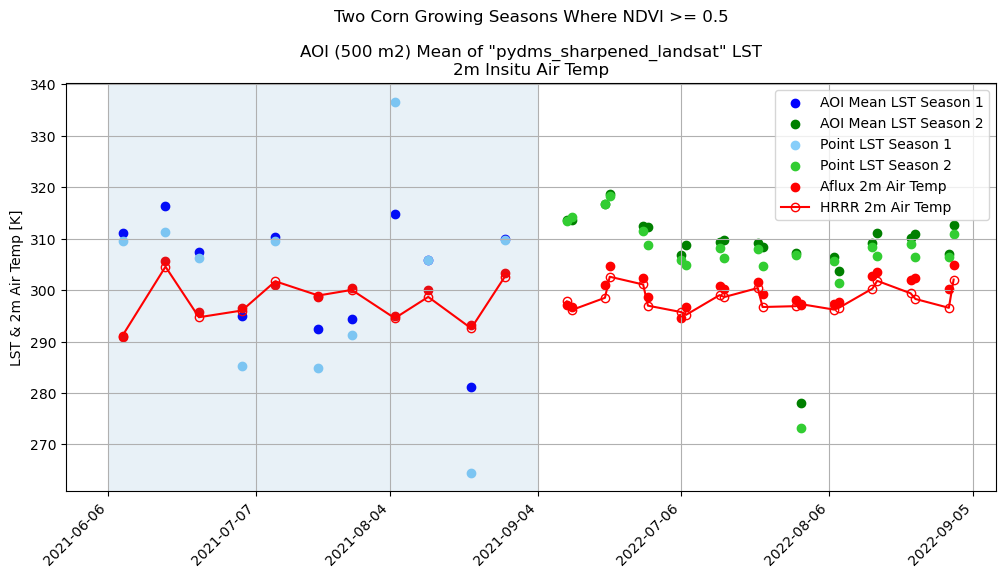

In [369]:
# Plot up a time series of of the daily AOI mean LST.

fig, ax = plt.subplots(figsize=(12, 6))

# Plot LST AOI mean data.
ax.scatter(lst_df1.index, lst_df1.starfm_lst, marker='o', c='blue', label="AOI Mean LST Season 1")
ax.scatter(lst_df2.index, lst_df2.starfm_lst, marker='o', c='green', label="AOI Mean LST Season 2")

# Plot LST point data.
ax.scatter(lst_time_series_df1.index, lst_time_series_df1.fused_lst, marker='o', c='lightskyblue', label="Point LST Season 1")
ax.scatter(lst_time_series_df2.index, lst_time_series_df2.fused_lst, marker='o', c='limegreen', label="Point LST Season 2")

# Plot insitu Temp for LST dates
ax.scatter(corn_met_df1.index.strftime('%Y-%m-%d'), (corn_met_df1['TA']+273), marker='o', c='red', label="Aflux 2m Air Temp")
ax.scatter(corn_met_df2.index.strftime('%Y-%m-%d'), (corn_met_df2['TA']+273), marker='o', c='red')

# Plot HRRR Temp for LST dates
ax.plot(hrrr_met_ds1.index, (hrrr_met_ds1['t2m']), marker='o', fillstyle='none', c='red', label="HRRR 2m Air Temp")
ax.plot(hrrr_met_ds2.index, (hrrr_met_ds2['t2m']), marker='o', fillstyle='none', c='red')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))

plt.gcf().autofmt_xdate()

plt.title('Two Corn Growing Seasons Where NDVI >= 0.5\n\nAOI (500 m2) Mean of "pydms_sharpened_landsat" LST\n2m Insitu Air Temp')
plt.axvspan('2021-06-06', '2021-09-04', alpha=.1)
plt.grid(True)
plt.ylabel('LST & 2m Air Temp [K]')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# Plot up a time series of of the daily AOI mean LST.
from xmlrpc.server import list_public_methods
import seaborn as sns

dt_list = []
val_list = []
df = pd.DataFrame()
for coor, sub_arr in aoi_lst_da1.groupby(aoi_lst_da1.time):
    
    dt_list.append(coor.strftime('%Y-%m-%d'))
    val_list.append(sub_arr.values)
    
df['date'] = dt_list
df['lst'] = val_list

fig, ax = plt.subplots(figsize=(12, 6))

#sns.catplot(data=df, x=df['date'], y=df['lst'].tolist(), kind='box')
#df.boxplot(column='lst', by=df['date'], ax=ax)



#plt.errorbar(lst_box_list_df.index, lst_box_list_df['mean_lst'], 
#             [lst_box_list_df['mean_lst'] - lst_box_list_df['min_lst'], 
#             lst_box_list_df['max_lst'] - lst_box_list_df['mean_lst']],
#             fmt='.k', ecolor='gray', lw=1)

#ax.boxplot(lst_box_list.index, lst_df1.starfm_lst, marker='o', c='blue', label="AOI Mean LST Season 1")

# Plot LST AOI mean data.
# ax.scatter(lst_df1.index, lst_df1.starfm_lst, marker='o', c='blue', label="AOI Mean LST Season 1")
# ax.scatter(lst_df2.index, lst_df2.starfm_lst, marker='o', c='green', label="AOI Mean LST Season 2")

# Plot LST point data.
# ax.scatter(lst_time_series_df1.index, lst_time_series_df1.fused_lst, marker='o', c='lightskyblue', label="Point LST Season 1")
# ax.scatter(lst_time_series_df2.index, lst_time_series_df2.fused_lst, marker='o', c='limegreen', label="Point LST Season 2")

# create stacked errorbars:
plt.errorbar(lst_box_list_df1.index.strftime('%Y-%m-%d'), lst_box_list_df1['mean_lst'], lst_box_list_df1['std_lst'], fmt='ok', color='blue', lw=1)
plt.errorbar(lst_box_list_df2.index.strftime('%Y-%m-%d'), lst_box_list_df2['mean_lst'], lst_box_list_df2['std_lst'], fmt='ok', color='green', lw=1)

# Plot insitu Temp for LST dates
ax.scatter(corn_met_df1.index.strftime('%Y-%m-%d'), (corn_met_df1['TA']+273), marker='o', c='red', label="2m Air Temp")
ax.scatter(corn_met_df2.index.strftime('%Y-%m-%d'), (corn_met_df2['TA']+273), marker='o', c='red')



ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))

plt.gcf().autofmt_xdate()

plt.title('Two Corn Growing Seasons Where NDVI >= 0.5\n\nAOI (500 m2) Mean of "pydms_sharpened_landsat" LST\n2m Insitu Air Temp')
plt.grid(True)
plt.ylabel('LST & 2m Air Temp [K]')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Calculate CATD & Plot CATD vs. VPD.

In [ ]:
# lst_df2 has all consecutive dates in it whereas corn_met_df2 has only
# the selected dates.  We need to drop the extra dates in lst before
# we do the subtraction.
lst_df2.dropna(how='all', axis=0, inplace=True)

# Calculate CATD.
catd_df2 = pd.DataFrame(['catd'])

catd_list = []
for i, ta in enumerate(corn_met_df2['TA'].values):

    catd = lst_df2['starfm_lst'][i] - (ta+273)
    catd_list.append(catd)

catd_df2 = pd.DataFrame(catd_list, index=lst_df2.index, columns=['catd'])

# Plot up a time series of of the daily AOI mean LST.
fig, ax = plt.subplots(figsize=(12, 6))

ax = plt.scatter(catd_df2, corn_met_df2['VPD']/10, marker='s', c='green')
plt.xlim(0,25)

plt.title('Corn Season 2\nVapor Pressure Deficit vs. CATD')
plt.grid(True)
plt.ylabel('VPD')
plt.xlabel('CATD')
#plt.xticks(rotation=45)
plt.show()


### Compute and plot a linear regression of catd and vpd.

Correlation Coefficient:
           catd       vpd
catd  1.000000 -0.101584
vpd  -0.101584  1.000000
Slope: [[-0.02046721]] This will be the B in our equation.
Intercept: [2.46203434] This will be the A in our equation.


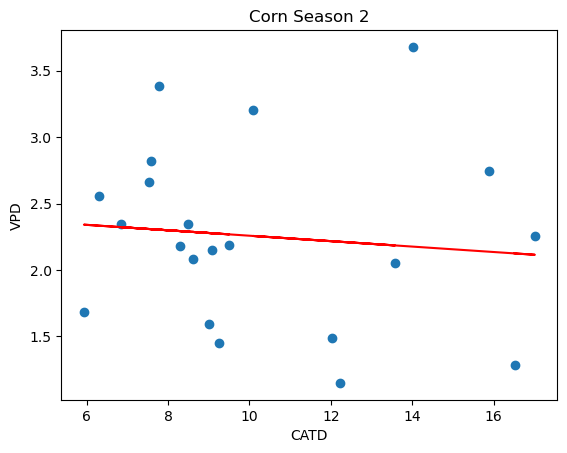

In [457]:
# Remove catd outliers.
catd_df2['catd'] = catd_df2['catd'].where(catd_df2['catd'] >= 0)

# Create a new df.  We want to have a complete df so
# we can drop any rows that has a NaN value.
# This version of linear regresion cant handle NaN.
catd_vpd_df = pd.DataFrame(columns=['catd', 'vpd'])

# Add data to dataframe.
# Covert vpd
catd_vpd_df['catd'] = catd_df2['catd'] 
catd_vpd_df['vpd'] = v = corn_met_df2['VPD']/10
catd_vpd_df.dropna(how="any", axis=0, inplace=True)

# Arrays need to be reshaped for some reason.
dd = catd_vpd_df['catd'].to_numpy().reshape(-1,1)
vv = catd_vpd_df['vpd'].to_numpy().reshape(-1,1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(dd,vv)  # perform linear regression
Y_pred = linear_regressor.predict(dd)  # make predictions

corr = catd_vpd_df.corr(method='pearson')

print('Correlation Coefficient:\n', corr)
print('Slope:' ,linear_regressor.coef_, "This will be the B in our equation.")
print('Intercept:', linear_regressor.intercept_, 'This will be the A in our equation.')

plt.scatter(dd, vv)
plt.plot(dd, Y_pred, color='red')
plt.ylabel('VPD')
plt.xlabel('CATD')
plt.title('Corn Season 2')
plt.show()

## <span style="color:green">Get Temp and Vapor Pressure from insitsu site.</span>
### I want to take the single temp value for each time step and broadcast it across
### a 25 x 25 array to match the LST dataarray.  Then, once the two dataarrays are of
### the same size and shape, I can subract the two to get a catd for each grid cell for each time step.

In [ ]:
# Get observed insitsu 'TA' and 'VPD_PI' from local csv files.

# AMF_US-Bi1_BASE_HH_8-5.csv
bi1_df = read_ameriflux(met_path)
# AMF_US-Bi2_BASE_HH_13-5
# bi2_df = read_ameriflux(bi2_data_path)
# AMF_US-DS3_BASE-BADM_1-5
# bi3_df = read_ameriflux(ds3_data_path)

#bi1_df.index = pd.to_datetime(bi1_df.index)
#utc_april_fools = bi1_df.index.astimezone(datetime.timezone.utc)
#print (bi1_df.index, utc_april_fools )

#bi1_df.TA
#bi1_df.VPD_PI

temp_list = []
vpd_list = []
da_temp_list = []
da_vpd_list = []

# Loop through each time step of the LST da.
for i in (aoi_lst_da.time):

    # Convert date to proper format
    dt = pd.to_datetime(i.item())
    dt = dt.tz_localize('UTC')

    # Get temp and VPD from the csv.
    ta = bi1_df.TA.iloc[bi1_df.index.get_indexer([dt], method='nearest')]
    #tas = bi1_df.TA.iloc[bi1_df.index.get_loc(dt, method='nearest')]
    # Convert vpd from hpa to kpa.
    vpd = bi1_df.VPD_PI.iloc[bi1_df.index.get_indexer([dt], method='nearest')] / 10
        
    # Save each temp in an array for later on.
    print (ta)
    temp_list.append(ta)
    # Convert vpd from hpa to kpa.
    vpd_list.append(vpd)

temp_df = pd.DataFrame(temp_list)
vpd_df = pd.DataFrame(vpd_list)
    # Build dataarray of temp and vpd. --------------------------------
'''
    # Create one datarray per time step.
    time = pd.date_range(dt, periods=1)

    # Use coords from LST da.
    temp_da = (xr.DataArray(
        data=ta,
        coords={'time': time, 'y': aoi_lst_da.y, 'x': aoi_lst_da.x, 'band':1},
        dims=['time', 'y', 'x'],
        name='TA',
        ))
  
    # Use coords from LST da.
    vpd_da = (xr.DataArray(
        data=vpd,
        coords={'time': time, 'y': aoi_lst_da.y, 'x': aoi_lst_da.x, 'band':1},
        dims=['time', 'y', 'x'],
        name='VPD',
        ))
            
    # Stick each da into a list.
    da_temp_list.append(temp_da)
    da_vpd_list.append(vpd_da)

# Concat the lists of das along time.
ta_stack = xr.concat(da_temp_list, dim="time")
vpd_stack = xr.concat(da_vpd_list, dim="time")
'''
temp_df

## <span style="color:green">Get DT formats consistent. </span>

In [383]:
## DT Format to match is strftime("%Y-%m-%dT%H:%M:%S.%f") ##
lst_time_vals = [datetime.strftime(t, format="%Y-%m-%dT%H:%M:%S.%f") for t in aoi_lst_da.time.values]
lst2_da = aoi_lst_da.assign_coords({"time": lst_time_vals})

# the ta_stack time variables need to be converted to datetime first (they are np.datetime64)
ta_time_vals = [datetime.strftime(pd.Timestamp(t), format="%Y-%m-%dT%H:%M:%S.%f") for t in ta_stack.time.values]
ta_stack2 = ta_stack.assign_coords({"time": ta_time_vals})

vpd_time_vals = [datetime.strftime(pd.Timestamp(t), format="%Y-%m-%dT%H:%M:%S.%f") for t in vpd_stack.time.values]
vpd_stack2 = vpd_stack.assign_coords({"time": vpd_time_vals})

# Check if they are the same.
# for i,j in zip(ta_stack2.time.values, lst2_da.time.values):
#     print(f"{i} == {j}, {i==j}")

## Calculate and Plot CATD

In [384]:
# Subtract the dataarrays to compute CATD.
# Convert from K to celcius first to match the insitsu obs.
#lst2_b0_da = (lst2_da.sel(band=1)) - 273.15
lst2_b0_da = (lst2_da) - 273.15

# Calculate CATD
catd_da = lst2_b0_da - ta_stack2

# centroid = aoi_df.geometry[0].centroid
# set_x, set_y, pixtype = (centroid.x, centroid.y, 'Center Pixel') 

# ax = catd_da.plot(x='x', y='y', col='time', col_wrap=5, vmin=-25, vmax=25)
# ax.set_xlabels('Easting [m]')
# ax.set_ylabels('Northing [m]')
# ax.map(lambda: plt.plot(set_x, set_y, markersize=20, marker=".", color="m"))

# plt.show()
centroid = aoi_df.geometry[0].centroid
set_x, set_y, pixtype = (centroid.x, centroid.y, 'Center Pixel') 

#print(lst2_b0_da.sel(x=set_x, y=set_y, method='nearest', tolerance=20).values, )
#print(ta_stack2.sel(x=set_x, y=set_y, method='nearest', tolerance=20).values.reshape(1,-1), )
#print(catd_da.sel(x=set_x, y=set_y, method='nearest', tolerance=20).values)

### Plot CATD values for all x and y against VPD 

In [ ]:
from matplotlib.dates import DateFormatter

centroid = aoi_df.geometry[0].centroid
set_x, set_y, pixtype = (centroid.x, centroid.y, 'Center Pixel') 

fig, ax1 = plt.subplots(figsize=(12, 6))
fig, ax2 = plt.subplots(figsize=(12, 6))

ax1.plot(lst2_b0_da.time, lst2_b0_da.sel(x=set_x, y=set_y, method='nearest', tolerance=20), c='green', label='LST')
ax1.plot(ta_stack2.time, ta_stack2.sel(x=set_x, y=set_y, method='nearest', tolerance=20), c='blue', label='Air Temp')

ax2.plot(catd_da.time, catd_da.sel(x=set_x, y=set_y, method='nearest', tolerance=20), c='red')

ax1.set_ylabel("Temperature", color='blue', fontsize=14)
ax2.set_ylabel("CATD", color='red', fontsize=14)

ax1.set_title(f"LST (LSAT), 2mT (Air) - California {analysis}")
ax2.set_title('CATD')

ax1.grid(True)
ax2.grid(True)

ax1.tick_params(axis='x', labelrotation = 45)
ax2.tick_params(axis='x', labelrotation = 45)

ax1.legend()

# Define the date format
date_form = DateFormatter("%m-%d-%y")
ax1.xaxis.set_major_formatter(date_form)

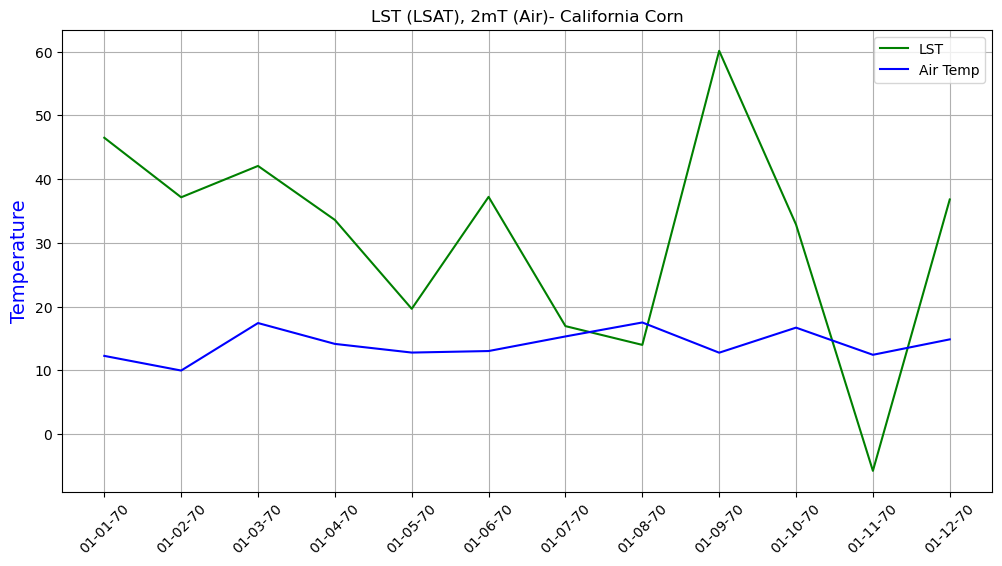

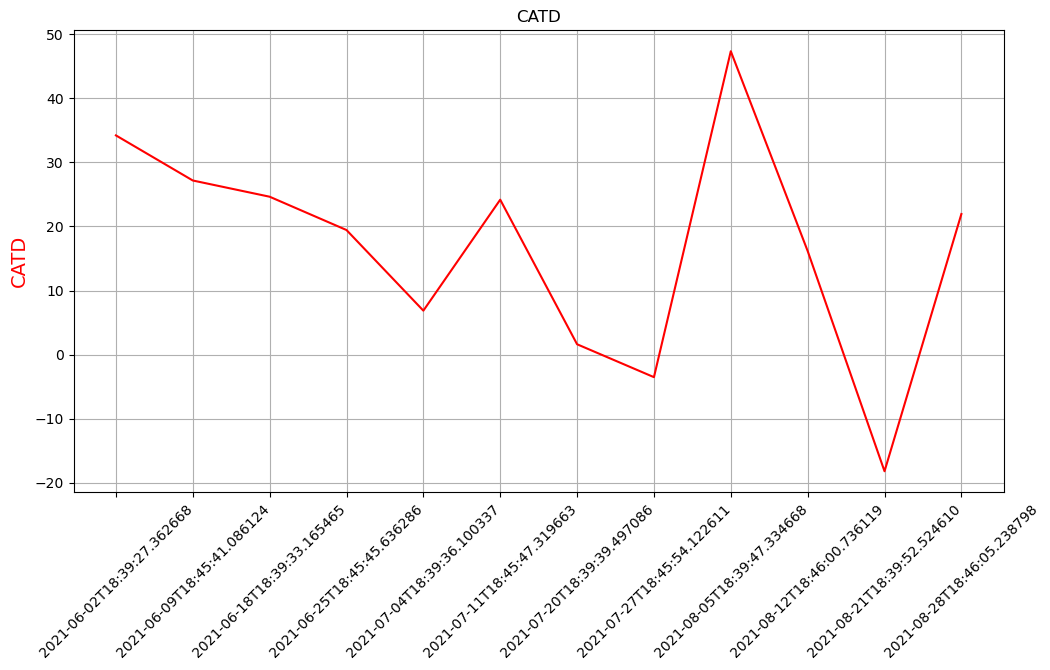

In [385]:

centroid = aoi_df.geometry[0].centroid
set_x, set_y, pixtype = (centroid.x, centroid.y, 'Center Pixel') 

fig, ax1 = plt.subplots(figsize=(12, 6))
fig, ax2 = plt.subplots(figsize=(12, 6))

ax1.plot(lst2_b0_da.time, lst2_b0_da.sel(x=set_x, y=set_y, method='nearest', tolerance=20), c='green', label='LST')
ax1.plot(ta_stack2.time, ta_stack2.sel(x=set_x, y=set_y, method='nearest', tolerance=20), c='blue', label='Air Temp')

ax2.plot(catd_da.time, catd_da.sel(x=set_x, y=set_y, method='nearest', tolerance=20), c='red')

ax1.set_ylabel("Temperature", color='blue', fontsize=14)
ax2.set_ylabel("CATD", color='red', fontsize=14)

ax1.set_title(f"LST (LSAT), 2mT (Air)- California {analysis}")
ax2.set_title('CATD')

ax1.grid(True)
ax2.grid(True)

ax1.tick_params(axis='x', labelrotation = 45)
ax2.tick_params(axis='x', labelrotation = 45)

ax1.legend()

# Define the date format
date_form = DateFormatter("%m-%d-%y")
ax1.xaxis.set_major_formatter(date_form)

## Compute quantiles to get upper & lower bounds of CATD vs VPD.

In [386]:

upper_list = []
lower_list = []
up_lo_list = []
time_list = []

for i, t in enumerate(catd_da):
    upper_list.append(np.percentile(t.values, 90))
    lower_list.append(np.percentile(t.values, 10))
    time_list.append(t.time.item())

catd_percentiles_df = pd.DataFrame(list(zip(time_list, upper_list, lower_list)),
               columns =['time', '90th', '10th'])

vpd_df = pd.DataFrame(list(zip(time_list, vpd_list)),
               columns =['time', 'vpd'])


## Linear Regression of CATD vs VPD

Slope: [[-0.00443707]] This will be the B in our equation.
Intercept: [0.50318675] This will be the A in our equation.


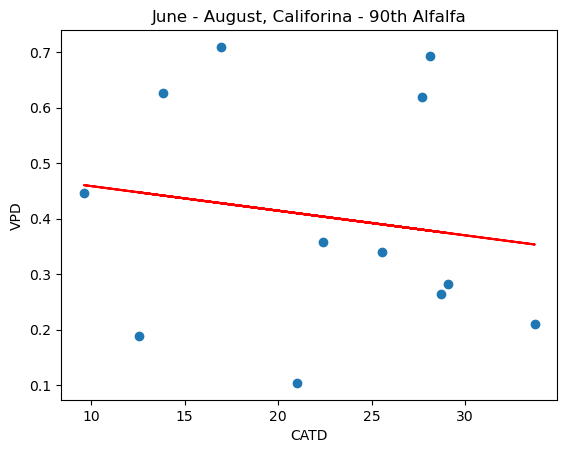

In [377]:
# Need numpy for the linear regression.
# We'll convert both of our dfs to nump and add them together.
# We'll do the same for time but oduble it up so we have arrays
# of the same lebgth.
#d = up_df['70th'].to_numpy() #+  
#v = vpd_df['vpd'].to_numpy() #+ 
d = catd_percentiles_df['90th'].to_numpy()
v = vpd_df['vpd'].to_numpy()

# Arrays need to be reshaped for some reason.
dd = d.reshape(-1,1)
vv = v.reshape(-1,1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(dd,vv)  # perform linear regression
Y_pred = linear_regressor.predict(dd)  # make predictions

print('Slope:' ,linear_regressor.coef_, "This will be the B in our equation.")
print('Intercept:', linear_regressor.intercept_, 'This will be the A in our equation.')

plt.scatter(dd, vv)
plt.plot(dd, Y_pred, color='red')
plt.ylabel('VPD')
plt.xlabel('CATD')
plt.title('June - August, Califorina - 90th {}'.format(analysis))
plt.show()

Slope: [[0.00238027]] This will be the B in our equation.
Intercept: [0.387292] This will be the A in our equation.


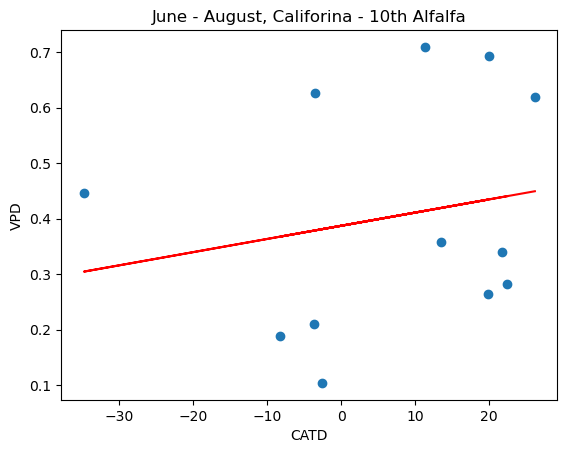

In [378]:
# Need numpy for the linear regression.
# We'll convert both of our dfs to nump and add them together.
# We'll do the same for time but oduble it up so we have arrays
# of the same lebgth.
#d = up_df['70th'].to_numpy() #+  
#v = vpd_df['vpd'].to_numpy() #+ 
d = catd_percentiles_df['10th'].to_numpy()
v = vpd_df['vpd'].to_numpy()

# Arrays need to be reshaped for some reason.
dd = d.reshape(-1,1)
vv = v.reshape(-1,1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(dd,vv)  # perform linear regression
Y_pred = linear_regressor.predict(dd)  # make predictions

print('Slope:' ,linear_regressor.coef_, "This will be the B in our equation.")
print('Intercept:', linear_regressor.intercept_, 'This will be the A in our equation.')

plt.scatter(dd, vv)
plt.plot(dd, Y_pred, color='red')
plt.ylabel('VPD')
plt.xlabel('CATD')
plt.title('June - August, Califorina - 10th {}'.format(analysis))
plt.show()

Slope: [[-0.00400019]] This will be the B in our equation.
Intercept: [0.53934472] This will be the A in our equation.


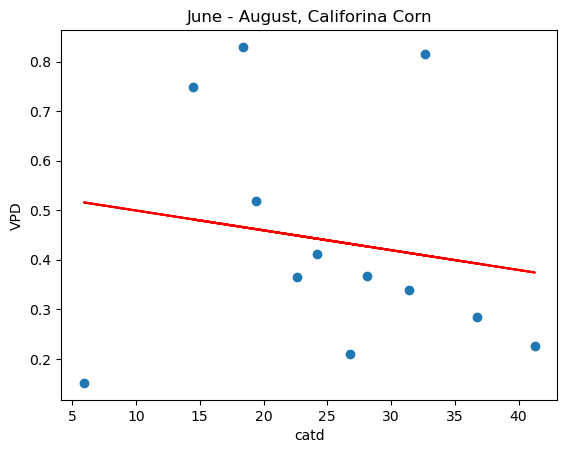

In [389]:
# Need numpy for the linear regression.
# We'll convert both of our dfs to nump and add them together.
# We'll do the same for time but oduble it up so we have arrays
# of the same lebgth.
#d = up_df['70th'].to_numpy() #+  
#v = vpd_df['vpd'].to_numpy() #+ 
d = catd_percentiles_df['90th'].to_numpy()
v = vpd_df['vpd'].to_numpy()

# Arrays need to be reshaped for some reason.
dd = d.reshape(-1,1)
vv = v.reshape(-1,1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(dd,vv)  # perform linear regression
Y_pred = linear_regressor.predict(dd)  # make predictions

print('Slope:' ,linear_regressor.coef_, "This will be the B in our equation.")
print('Intercept:', linear_regressor.intercept_, 'This will be the A in our equation.')

plt.scatter(dd, vv)
plt.plot(dd, Y_pred, color='red')
plt.ylabel('VPD')
plt.xlabel('catd')
plt.title('June - August, Califorina {}'.format(analysis))
plt.show()

Slope: [[0.00010137]] This will be the B in our equation.
Intercept: [0.43776838] This will be the A in our equation.


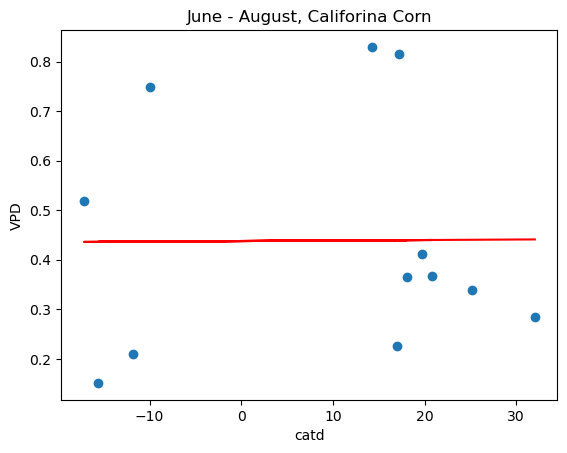

In [390]:
# Need numpy for the linear regression.
# We'll convert both of our dfs to nump and add them together.
# We'll do the same for time but oduble it up so we have arrays
# of the same lebgth.
#d = up_df['70th'].to_numpy() #+  
#v = vpd_df['vpd'].to_numpy() #+ 
d = catd_percentiles_df['10th'].to_numpy()
v = vpd_df['vpd'].to_numpy()

# Arrays need to be reshaped for some reason.
dd = d.reshape(-1,1)
vv = v.reshape(-1,1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(dd,vv)  # perform linear regression
Y_pred = linear_regressor.predict(dd)  # make predictions

print('Slope:' ,linear_regressor.coef_, "This will be the B in our equation.")
print('Intercept:', linear_regressor.intercept_, 'This will be the A in our equation.')

plt.scatter(dd, vv)
plt.plot(dd, Y_pred, color='red')
plt.ylabel('VPD')
plt.xlabel('catd')
plt.title('June - August, Califorina {}'.format(analysis))
plt.show()

### CWSI-EB (Crop Water Stress Index) - Katimbo et al (2022) in Agricultural Water Management.

CWSI = ((Tc - Ta)a - (Tcl - Ta)U) / ((Tcu - Ta)L - (Tcl - Ta)L)

    Tc = canopy Temp (fused LST)
    Ta = ambient air temp (HRRR 2mT)
    Tcl = Tc of well transpiring veg (from aoi.max)
    Tcu = Tc of non-transpiring veg (from aoi.min)
    
    (Tcl - Ta)L = A + B * VPD

        VPD = e - es
        e = 6.11 × 10 exp(7.5 × Td / 237.3 + Td )
        es = 6.11 × 10 exp(7.5 × T / 237.3 + T )
        A = intercept of a regression of (Tc - Ta) and VPD
        B = slope of a regression of (Tc - Ta) and VPD

    (Tc - Ta)a = A + B * VPG
    
        VPG = Ta - (Ta + A)
        A = intercept of a regression of (Tc - Ta) and VPD
        B = slope of a regression of (Tc - Ta) and VPD